In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
from os import path
import numpy as np

from ast import literal_eval
import json

In [68]:
DATE = "2019-12-04 22:32:52.089551"
CSV_RESULTS = f"{DATE}_FULL_RESULTS"

df = pd.read_csv(f"{CSV_RESULTS}.csv", index_col=0)
df = df[df["optim"] == "Adam"]

In [69]:
if not path.isdir('./results'): os.mkdir("./results")

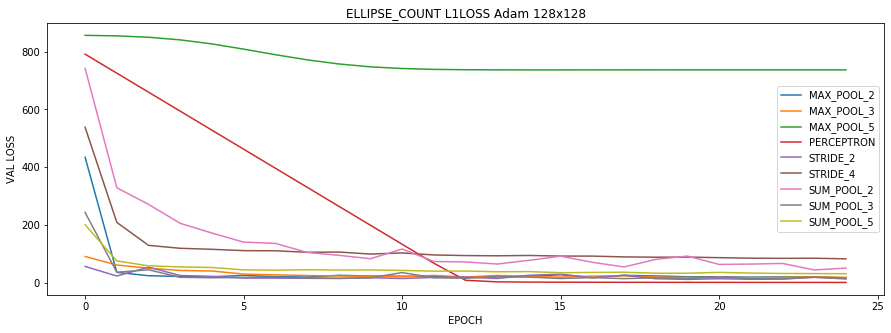

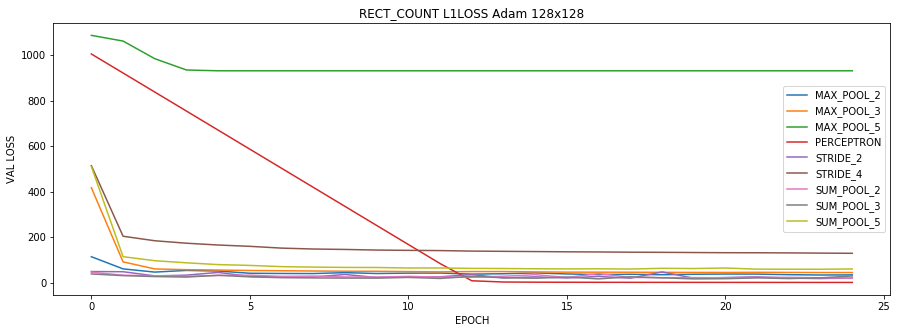

In [72]:
for dt, dt_group in df.groupby(['dataset', 'loss_fn', 'optim']):
    plt.figure(figsize=(15, 5))
    for i, group in dt_group.groupby(['model_name']):
            label = f"{i}"
            plt.plot(group["epoch"], group["val_loss_avg"], label=f"{label}")
    plt.title(f'{dt[0]} {dt[1]} {dt[2]} 128x128')
    plt.xlabel('EPOCH')
    plt.ylabel('VAL LOSS')
    plt.legend()
    results_dest = f"./results/{CSV_RESULTS}/not_normalized"
    if not path.isdir(results_dest): os.makedirs(results_dest)
    plt.savefig(f'{results_dest}/{dt[0]}_{dt[1]}_val_losses.png')

In [7]:
df_count = df[df["dataset"].str.contains("COUNT")].copy()
df_pct = df[df["dataset"].str.contains("PCT")].copy()

df_count_l1 = df_count[df_count["loss_fn"] == "L1LOSS"].copy() 
df_count_l1["normalized_val_loss_avg"] = df_count_l1["val_loss_avg"] / 1024

df_count_mse = df_count[df_count["loss_fn"] == "MSELOSS"].copy() 
df_count_mse["normalized_val_loss_avg"] = (df_count_mse["val_loss_avg"] ** (1/2)) / 1024

df_normalized_results = pd.concat([df_count_l1, df_count_mse, df_pct], sort=False)
df_normalized_results.sort_values(by="normalized_val_loss_avg", ascending=False)

,dataset,epoch,loss_fn,model_name,optim,train_loss,train_loss_avg,val_loss,val_loss_avg,normalized_val_loss_avg
125,RECT_COUNT,0.0,L1LOSS,MAX_POOL_5,Adam,85802.049377,1086.101891,68493.139221,1087.192686,1.061712
126,RECT_COUNT,1.0,L1LOSS,MAX_POOL_5,Adam,85054.226135,1076.635774,66914.572632,1062.136074,1.037242
200,RECT_COUNT,0.0,L1LOSS,PERCEPTRON,Adam,82613.887085,1045.745406,63328.372314,1005.212259,0.981653
127,RECT_COUNT,2.0,L1LOSS,MAX_POOL_5,Adam,80917.248962,1024.268974,62033.156433,984.653277,0.961575
128,RECT_COUNT,3.0,L1LOSS,MAX_POOL_5,Adam,75158.039734,951.367592,58900.635010,934.930714,0.913018
...,...,...,...,...,...,...,...,...,...,...
220,RECT_COUNT,20.0,L1LOSS,PERCEPTRON,Adam,119.976275,1.518687,96.896887,1.538046,0.001502
221,RECT_COUNT,21.0,L1LOSS,PERCEPTRON,Adam,114.111325,1.444447,93.285852,1.480728,0.001446
222,RECT_COUNT,22.0,L1LOSS,PERCEPTRON,Adam,109.077503,1.380728,89.525447,1.421039,0.001388
223,RECT_COUNT,23.0,L1LOSS,PERCEPTRON,Adam,104.230336,1.319371,86.058125,1.366002,0.001334


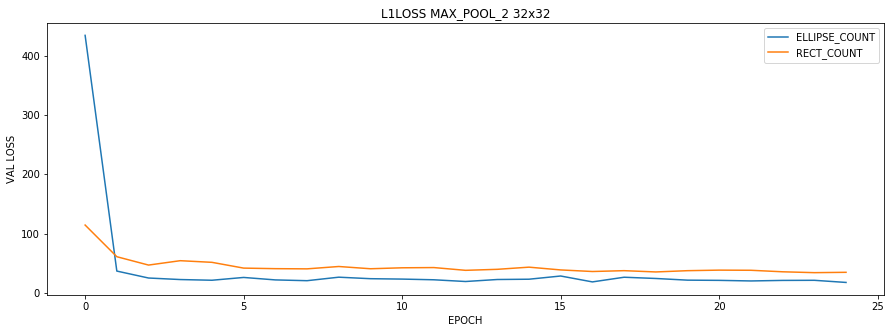

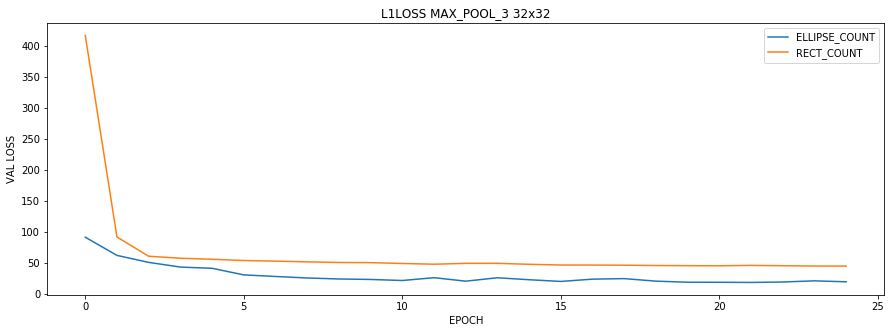

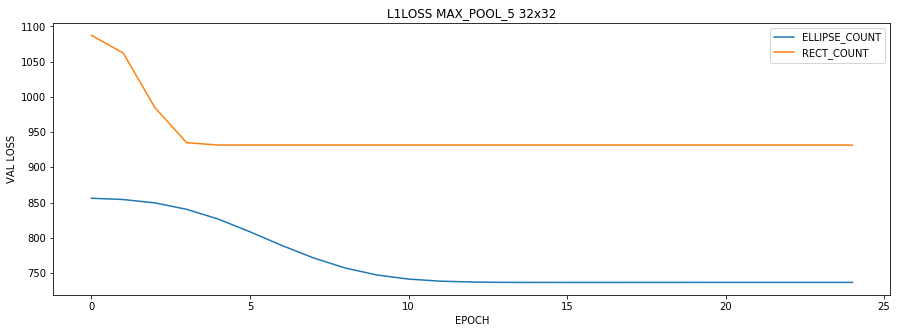

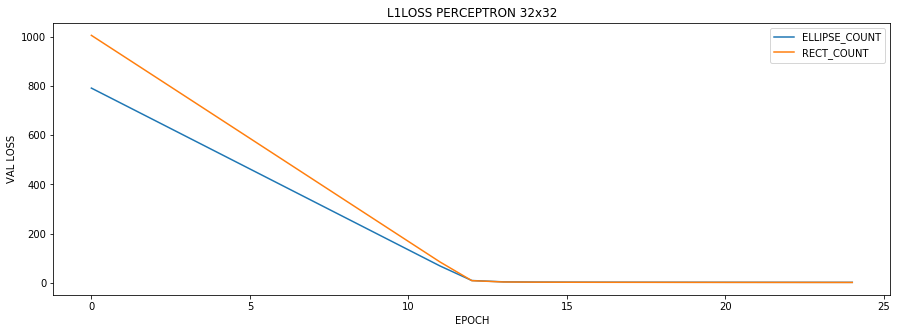

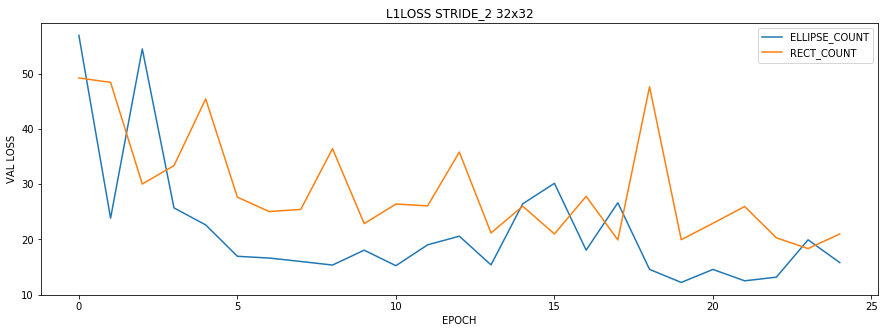

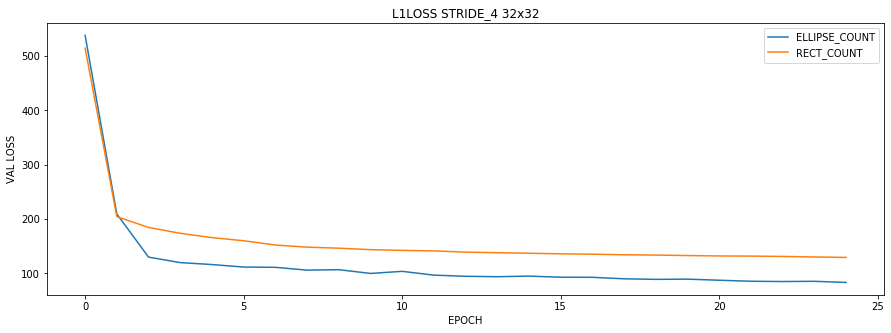

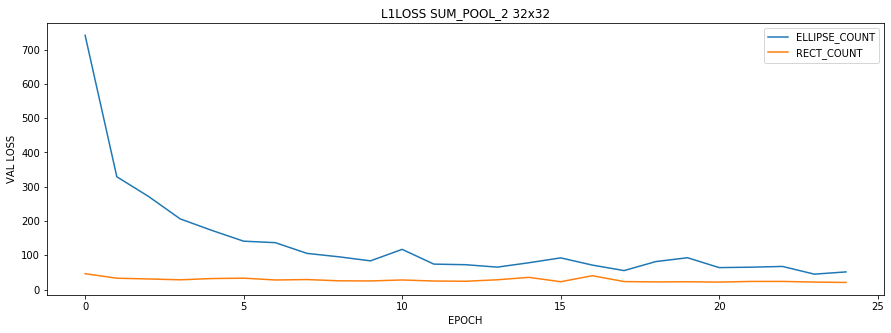

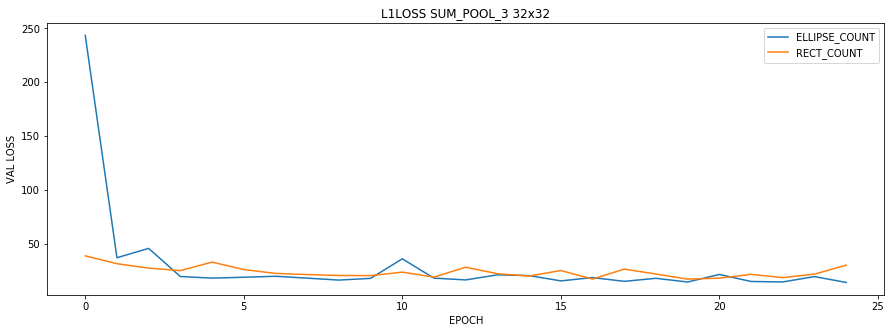

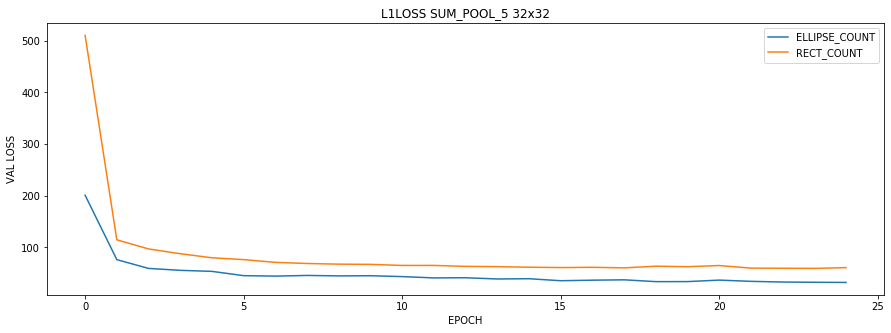

In [9]:
for dt, dt_group in df_normalized_results.groupby(['loss_fn', 'model_name']):
    plt.figure(figsize=(15, 5))
    for i, group in dt_group.groupby(['dataset']):
        label = f"{i}"
        #if "COUNT" in i: plt.plot(group["epoch"], group["normalized_val_loss_avg"], label=f"{label}-NORMALIZED_FROM_COUNT")
        #else           : 
        plt.plot(group["epoch"], group["val_loss_avg"], label=f"{label}")
    
    plt.title(f'{dt[0]} {dt[1]} 32x32')
    plt.xlabel('EPOCH')
    plt.ylabel('VAL LOSS')
    plt.legend()
    results_dest = f"./results/{CSV_RESULTS}/normalized"
    if not path.isdir(results_dest): os.makedirs(results_dest)
    plt.savefig(f'{results_dest}/{dt[0]}_{dt[1]}_val_losses_more_epochs_NORMALIZED.png')

In [44]:
df_reduced = pd.DataFrame(columns=["model_name", "loss_fn", "dataset", "optim", "min_val_loss_row", "epoch"])
for i, group in df_normalized_results.groupby(["dataset", "model_name", "loss_fn", "optim"]):
    is_pct = "PCT" in i[0]
    if is_pct: min_val_loss_idx = group["val_loss_avg"].idxmin() 
    else              : min_val_loss_idx = group["normalized_val_loss_avg"].idxmin()
    min_val_loss_row = group.loc[min_val_loss_idx]
    min_val_loss_row = pd.Series({
        "model_name"       : min_val_loss_row.model_name,
        "loss_fn"          : min_val_loss_row.loss_fn,
        "dataset"   : min_val_loss_row.dataset,
        "optim"            : min_val_loss_row.optim,
        "epoch"            : min_val_loss_row.epoch,
        "min_val_loss_row" : min_val_loss_row.val_loss_avg # if is_pct else min_val_loss_row.normalized_val_loss_avg
    })
    df_reduced = df_reduced.append(min_val_loss_row, ignore_index=True)

for dt, group in df_reduced.sort_values(by=["dataset", "min_val_loss_row"]).groupby('dataset'):
    group.to_csv(f"./results/{DATE}_FULL_RESULTS/{dt}_best_.csv")

ELLIPSE_COUNT
RECT_COUNT


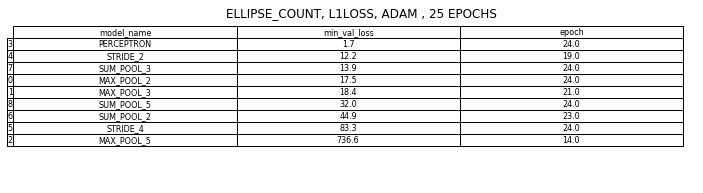

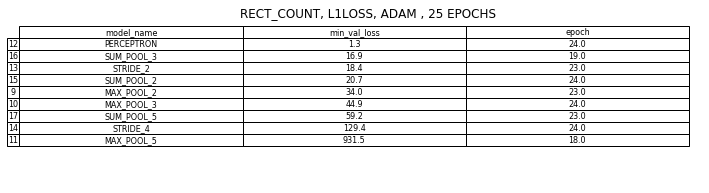

In [67]:
for i, d in df_reduced.sort_values(by="min_val_loss_row").groupby('dataset'):
    fig, ax = plt.subplots(figsize=(12, 3)) 
    print(i)
    ax.xaxis.set_visible(False)  
    ax.yaxis.set_visible(False)  
    ax.set_frame_on(False)  
    to_table = d[["model_name", "epoch"]].copy()
    to_table["min_val_loss"] = d["min_val_loss_row"].copy().round(1)
    tab = table(
        ax, 
        to_table[["model_name", "min_val_loss", "epoch"]], 
        loc='upper right', 
        cellLoc="center",
        rowLoc="center"
    )
    tab.auto_set_font_size(False)
    tab.set_fontsize(8) 
    plt.title(f"{i}, L1LOSS, ADAM , 25 EPOCHS")
    #plt.show()
    plt.savefig(f'./results/{DATE}_FULL_RESULTS/{i}_best_.png')

In [54]:
d["min_val_loss_row"].round(1)

12      1.3
16     16.9
13     18.4
15     20.7
9      34.0
10     44.9
17     59.2
14    129.4
11    931.5
Name: min_val_loss_row, dtype: float64